---

<h1><center><font color='#82ad32'>Gasto Público em Educação x Desempenho no PISA</font></center></h1>

---
Link para a apresentação [aqui](https://drive.google.com/file/d/1Yio6a-DK5tmZ_Wa7uIHvt-6I2OKgyPlr/view?usp=sharing)

O objetivo deste trabalho é avaliar possíveis correlações entre o gasto público de um país em educação e o desempenho dos alunos deste país na prova do Programa Internacional de Avaliação de Estudantes (PISA). Todas as informações necessárias foram baixadas no site de dados da OCDE [aqui](https://data.oecd.org/), onde é possível encontrar o histórico dos indicadores pertinentes em formato ```.csv```. 

Vale notar que por gasto público em educação nos referimos à porcentagem do PIB investida pelo país na educação primária e secundária. O desempenho do país no PISA, por sua vez, faz referência à nota de cada país na prova e está dividido em três bases, uma para cada área do conhecimento avaliada: Leitura, Matemática e Ciência. Maiores informações a respeito do PISA podem ser encontradas [aqui](http://portal.inep.gov.br/pisa), no site do INEP.

### <font color='#82ad32'>Divisão do Trabalho</font>

0. Importação das Bibliotecas e Estilização Visual
1. Input das Bases
2. Tratamento das Bases
3. Unificação das Bases
4. Análise Exploratória dos Dados
5. Correlação entre Gasto Público em Educação x Desempenho no PISA


---

## <font color='#82ad32'>0. Importação das Bibliotecas e Estilização Visual

In [294]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#Estilização Visual
plt.rcParams['font.family'] = 'monospace'
plt.rc("axes.spines", top=False, right=False, left=False)

grey = '#363636'

plt.rcParams['axes.linewidth'] = 0.3
plt.rcParams['axes.edgecolor'] = grey
plt.rcParams['xtick.color'] = grey
plt.rcParams['ytick.color'] = grey

---

## <font color='#82ad32'>1. Input das Bases

In [295]:
# Gasto Público em Educação
gp_educ = pd.read_csv('gasto_publico_educ_00-15.csv')

# Desempenho no PISA
# Matemática
pisa_m = pd.read_csv('pisa_mat_03-18.csv')
# Leitura
pisa_l = pd.read_csv('pisa_leitura_00-18.csv')
# Ciência
pisa_c = pd.read_csv('pisa_sci_06-18.csv')

# Chaves para cruzar os dados com seus paises e Continentes
gapminder_keys = px.data.gapminder()[['country', 
                                      'continent', 
                                      'iso_alpha']
                                    ].drop_duplicates().reset_index(drop=True)

---

## <font color='#82ad32'>2. Tratamento das Bases

In [296]:
#Selecionando apenas colunas pertinentes
gp_educ.drop(['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)

pisa_m.drop( ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)
pisa_l.drop( ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)
pisa_c.drop( ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)

#Com isso, todas as bases contêm apenas o nome do país, o valor do indicador e o ano.

In [88]:
#Renomeando as colunas para maior comodidade 
gp_educ.columns = ['country','Ano','Gasto Educ (%)']
pisa_m.columns  = ['country','Ano','Nota Matemática']
pisa_l.columns  = ['country','Ano','Nota Leitura']
pisa_c.columns  = ['country','Ano','Nota Ciências']

gapminder_keys.columns = ['País', 'Continente', 'country'] # country vira o iso_alpha

In [89]:
#Avaliando se as colunas estão sendo lidas corretamente. Ano e Valor devem ser lidos como números inteiros (int)
#ou fracionados (float)

print(gp_educ.dtypes)
print()
print(pisa_m.dtypes)
print()
print(pisa_c.dtypes)
print()
print(pisa_l.dtypes)

country            object
Ano                 int64
Gasto Educ (%)    float64
dtype: object

country            object
Ano                 int64
Nota Matemática     int64
dtype: object

country          object
Ano               int64
Nota Ciências     int64
dtype: object

country         object
Ano              int64
Nota Leitura     int64
dtype: object


---

## <font color='#82ad32'>3. Unificação das Bases

In [90]:
#Para unificar as bases, precisamos de uma coluna para usar de referência. Como os valores fazem referência a um país e a um ano
#simultaneamente, vamos concatenar a coluna país com a coluna ano. Com isso, essa coluna concatenada poderá ser usada para 
#cruzar as bases sem perda de informação.

gp_educ['País-Ano'] = gp_educ['country'] + '-' + gp_educ['Ano'].astype(str)

pisa_m['País-Ano']  = pisa_m['country']  + '-' + pisa_m['Ano'].astype(str)
pisa_l['País-Ano']  = pisa_l['country']  + '-' + pisa_l['Ano'].astype(str)
pisa_c['País-Ano']  = pisa_c['country']  + '-' + pisa_c['Ano'].astype(str)

In [91]:
#Concatenando as bases
base = pd.concat([gp_educ,pisa_m,pisa_l,pisa_c],axis=0,sort=False)
#Com isso, a variável 'base' estará agrupada, mas terá valores repetidos para o país-ano 
#(duas linhas para Brasil-2005, por exemplo)

#Para termos apenas um valor para cada país-ano, vamos agrupar a base na coluna País-Ano utilizando como função a mínimo. 
#Poderíamos aqui utilizar outras funções que não a mínimo, pois só existe 1 valor de cada indicador para cada país-ano.
#Se fizessemos a função max(), por exemplo, o resultado seria o mesmo, pois o mínimo de [nan,nan,x] é igual ao
#máximo de [nan,nan,x], já que só possui um valor - nan não conta.

base_group = base.groupby('País-Ano').min()

base_group = base_group.merge(gapminder_keys, on='country', how='left')

---

## <font color='#82ad32'>4. Análise Exploratória dos Dados

Vamos ver quantos lançamentos existem por continente. 

In [92]:
base_group.groupby(['País',
                    'Continente'],
                   as_index=False).count()[['País',
                                            'Continente']].groupby('Continente').count()

,País
Continente,
Africa,1
Americas,9
Asia,11
Europe,23
Oceania,2


Conforme pode ser visto, a maior parte dos países é europeu. Também vimos que no caso da África existe apenas 1 país, apesar do continente possuir bem mais. Por isso, decidimos omitir a África da base - além de possuir apenas 1, o país em questão é a África do Sul, que é [o terceiro país mais rico do continente](https://en.wikipedia.org/wiki/List_of_African_countries_by_GDP_(nominal)) e portanto não é representativo.

In [93]:
base_group = base_group[base_group['Continente']!='Africa'] 

Feito isso, vamos buscar entender o comportamento das bases. Antes de mais nada, veremos quais são as estatísticas descritivas.

In [94]:
base_group.describe()[['Gasto Educ (%)', 'Nota Matemática', 'Nota Leitura','Nota Ciências']]

,Gasto Educ (%),Nota Matemática,Nota Leitura,Nota Ciências
count,375.000000,242.000000,270.000000,207.000000
mean,3.283661,488.107438,487.051852,491.352657
std,0.673434,41.439613,34.827417,36.545573
min,1.543000,356.000000,371.000000,382.000000
25%,2.750000,481.000000,476.000000,479.500000
50%,3.241000,495.000000,494.000000,498.000000
75%,3.734500,514.000000,507.750000,514.500000
max,5.031000,564.000000,556.000000,563.000000


Percebemos que o count das colunas não é igual. Isto significa que não existem todos os indicadores, todos os anos para todos os países. Isto é um problema, pois implica que precisaremos lidar com esses espaços vazios.

Quanto ao Gasto Público em educação, percebemos que existe uma amplitude grande - de 1.5% à 5.1% de investimento -, com uma média de 3.29%

Já as notas do PISA possuem médias muito parecidas, entre 485 e 490 pontos. Também possuem distribuições muito similares.

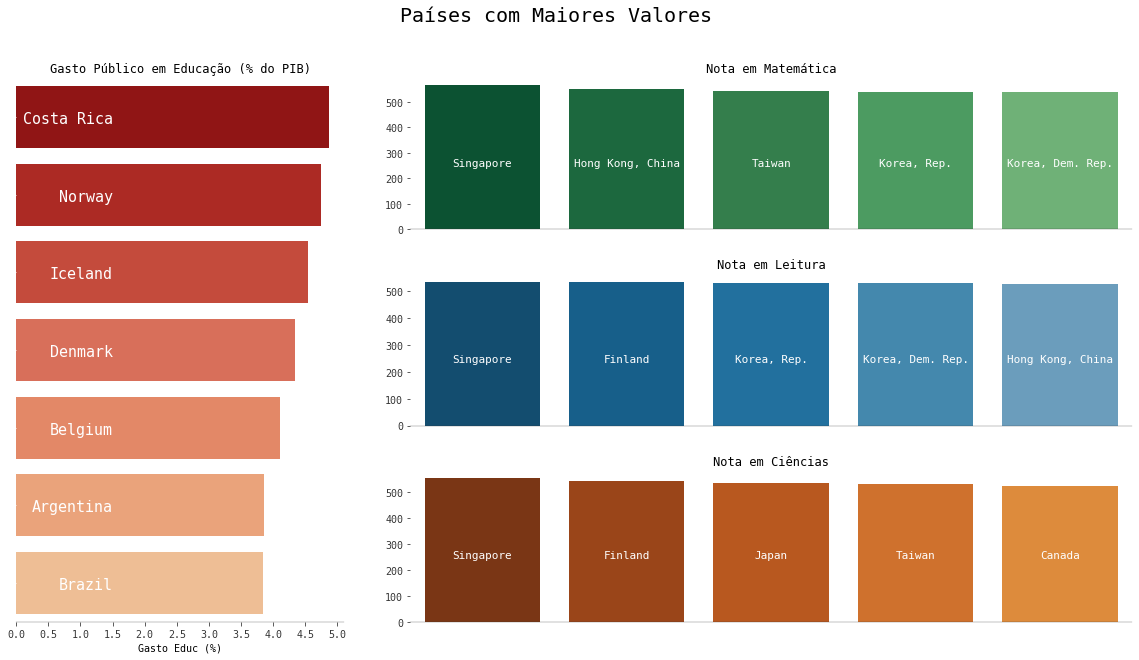

In [301]:
base_group_country = base_group.groupby(['País','country']).mean().reset_index()

#Vamos visualizar as distribuições dessas colunas.
fig = plt.figure(figsize=(20,10))

#Gerando um espaço de imagem do matplotlib
gs = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.3,figure=fig)

#Criando os sub-espaços (1 maior, e 3 menores)
#No código abaixo estamos forçando os gráficos do PISA a terem todos os mesmo eixo X.
ax0 = fig.add_subplot(gs[0, 1:])
plt.xticks(fontsize=9)
plt.title('Nota em Matemática')

ax1 = fig.add_subplot(gs[1, 1:])
plt.xticks(fontsize=9)
plt.title('Nota em Leitura')

ax2 = fig.add_subplot(gs[2, 1:])
plt.xticks(fontsize=9)
plt.title('Nota em Ciências')

ax3 = fig.add_subplot(gs[:, 0])
plt.yticks([])
plt.xticks([x/100 for x in range(0,700,50)])
plt.title('Gasto Público em Educação (% do PIB)')

ax0.axes.get_xaxis().get_label().set_visible(False)
ax1.axes.get_xaxis().get_label().set_visible(False)
ax2.axes.get_xaxis().get_label().set_visible(False)
ax0.axes.get_yaxis().get_label().set_visible(False)
ax1.axes.get_yaxis().get_label().set_visible(False)
ax2.axes.get_yaxis().get_label().set_visible(False)
ax3.axes.get_yaxis().get_label().set_visible(False)

#Plotando os gráficos de distribuição.
g3 = sns.barplot(data=base_group_country.sort_values('Gasto Educ (%)',ascending=False)[:7],x='Gasto Educ (%)',y='País',
                 ci=0,ax=ax3,palette=sns.color_palette("OrRd", 10)[::-1])
g3.tick_params(axis="y",direction="out", pad=-100,colors='white',labelsize=15)

g0 = sns.barplot(data=base_group_country.sort_values('Nota Matemática',ascending=False)[:5],y='Nota Matemática',x='País',
                 ax=ax0,palette=sns.color_palette("YlGn", 10)[3:][::-1])
g0.tick_params(axis="x",direction="out", pad=-75,colors='white',labelsize=11)

g1 = sns.barplot(data=base_group_country.sort_values('Nota Leitura',ascending=False)[:5],y='Nota Leitura',x='País',
                 ax=ax1,palette=sns.color_palette("PuBu", 10)[5:][::-1])
g1.tick_params(axis="x",direction="out", pad=-75,colors='white',labelsize=11)

g2 = sns.barplot(data=base_group_country.sort_values('Nota Ciências',ascending=False)[:5],y='Nota Ciências',x='País',
                 ax=ax2,palette=sns.color_palette("YlOrBr", 10)[5:][::-1])
g2.tick_params(axis="x",direction="out", pad=-75,colors='white',labelsize=11)

fig.suptitle('Países com Maiores Valores',fontsize=20)
plt.show()

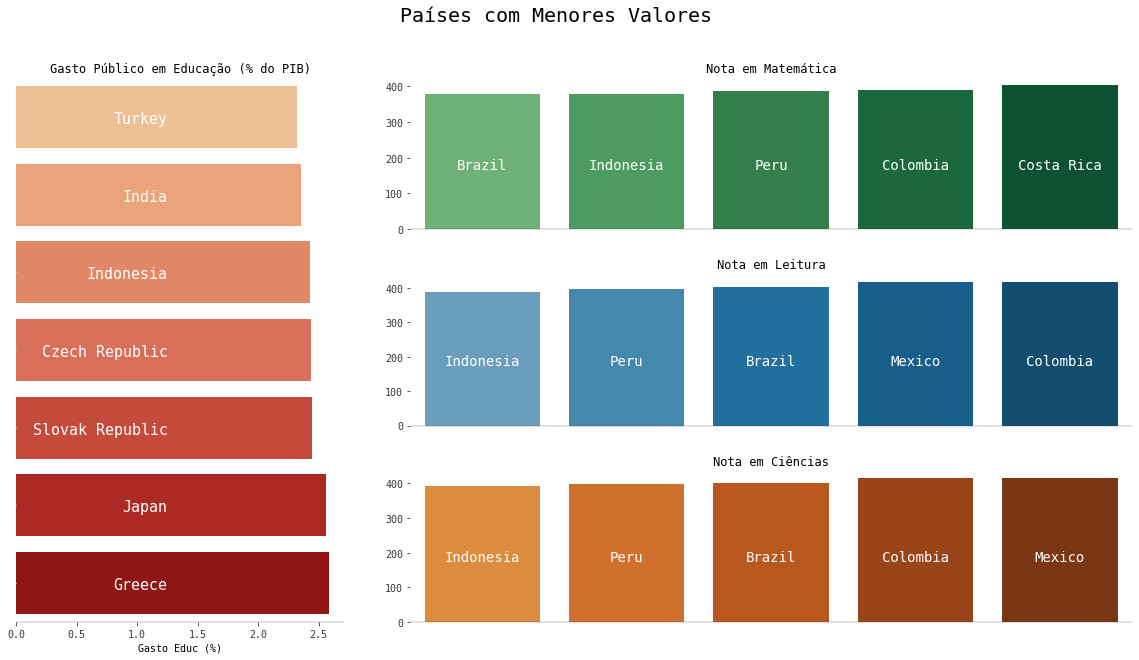

In [310]:
base_group_country = base_group.groupby(['País','country']).mean().reset_index()

#Vamos visualizar as distribuições dessas colunas.
fig = plt.figure(figsize=(20,10))

#Gerando um espaço de imagem do matplotlib
gs = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.3,figure=fig)

#Criando os sub-espaços (1 maior, e 3 menores)
#No código abaixo estamos forçando os gráficos do PISA a terem todos os mesmo eixo X.
ax0 = fig.add_subplot(gs[0, 1:])
plt.xticks(fontsize=9)
plt.title('Nota em Matemática')

ax1 = fig.add_subplot(gs[1, 1:])
plt.xticks(fontsize=9)
plt.title('Nota em Leitura')

ax2 = fig.add_subplot(gs[2, 1:])
plt.xticks(fontsize=9)
plt.title('Nota em Ciências')

ax3 = fig.add_subplot(gs[:, 0])
plt.yticks([])
plt.xticks([x/100 for x in range(0,700,50)])
plt.title('Gasto Público em Educação (% do PIB)')

ax0.axes.get_xaxis().get_label().set_visible(False)
ax1.axes.get_xaxis().get_label().set_visible(False)
ax2.axes.get_xaxis().get_label().set_visible(False)
ax0.axes.get_yaxis().get_label().set_visible(False)
ax1.axes.get_yaxis().get_label().set_visible(False)
ax2.axes.get_yaxis().get_label().set_visible(False)
ax3.axes.get_yaxis().get_label().set_visible(False)

#Plotando os gráficos de distribuição.
g3 = sns.barplot(data=base_group_country.sort_values('Gasto Educ (%)',ascending=True)[:7],x='Gasto Educ (%)',y='País',
                 ci=0,ax=ax3,palette=sns.color_palette("OrRd", 10)[3:])
g3.tick_params(axis="y",direction="out", pad=-155,colors='white',labelsize=15)

g0 = sns.barplot(data=base_group_country.sort_values('Nota Matemática',ascending=True)[:5],y='Nota Matemática',x='País',
                 ax=ax0,palette=sns.color_palette("YlGn", 10)[5:])
g0.tick_params(axis="x",direction="out", pad=-75,colors='white',labelsize=14)

g1 = sns.barplot(data=base_group_country.sort_values('Nota Leitura',ascending=True)[:5],y='Nota Leitura',x='País',
                 ax=ax1,palette=sns.color_palette("PuBu", 10)[5:])
g1.tick_params(axis="x",direction="out", pad=-75,colors='white',labelsize=14)

g2 = sns.barplot(data=base_group_country.sort_values('Nota Ciências',ascending=True)[:5],y='Nota Ciências',x='País',
                 ax=ax2,palette=sns.color_palette("YlOrBr", 10)[5:])
g2.tick_params(axis="x",direction="out", pad=-75,colors='white',labelsize=14)

fig.suptitle('Países com Menores Valores',fontsize=20)
plt.show()

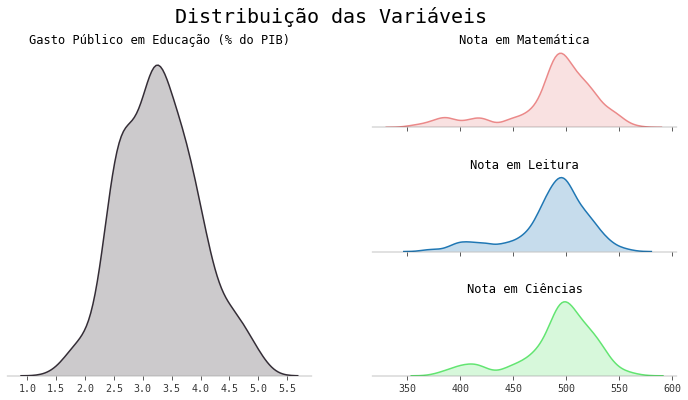

In [291]:
#Vamos visualizar as distribuições dessas colunas.
fig = plt.figure(figsize=(12,6))

#Gerando um espaço de imagem do matplotlib
gs = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.6,figure=fig)

#Criando os sub-espaços (1 maior, e 3 menores)
#No código abaixo estamos forçando os gráficos do PISA a terem todos os mesmo eixo X.
ax0 = fig.add_subplot(gs[0, 1])
plt.yticks([])
plt.yticks([])
plt.title('Nota em Matemática')
plt.setp(ax0.get_xticklabels(), visible=False)

ax1 = fig.add_subplot(gs[1, 1],sharex=ax0)
plt.yticks([])
plt.title('Nota em Leitura')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(gs[2, 1],sharex=ax0)
plt.yticks([])
plt.title('Nota em Ciências')

ax3 = fig.add_subplot(gs[:, 0])
plt.yticks([])
plt.xticks([x/100 for x in range(100,700,50)])
plt.title('Gasto Público em Educação (% do PIB)')

#Plotando os gráficos de distribuição.
sns.distplot(base_group['Gasto Educ (%)'],ax=ax3,hist=False,axlabel=False,kde_kws={"shade": True},color='#342d36')
sns.distplot(base_group['Nota Matemática'],ax=ax0,hist=False,axlabel=False,kde_kws={"shade": True},color='#eb8989')
sns.distplot(base_group['Nota Leitura'],ax=ax1,hist=False,kde_kws={"shade": True},axlabel=False)
sns.distplot(base_group['Nota Ciências'],ax=ax2,hist=False,axlabel=False,kde_kws={"shade": True},color='#62e571')

fig.suptitle('Distribuição das Variáveis',fontsize=20)
plt.show()

As visualizações estatísticas mostram que as variáveis para as notas são parecidas. Vamos verificar a correlação entre elas.

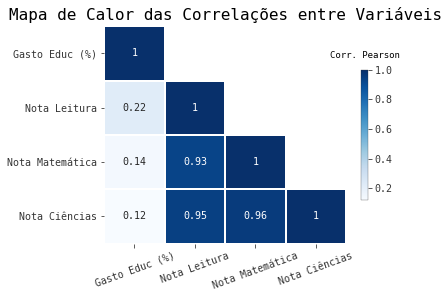

In [321]:
mask = np.zeros_like(base_group[['Gasto Educ (%)','Nota Leitura','Nota Matemática','Nota Ciências']].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

fig, ax = plt.subplots()

sns.heatmap(base_group[['Gasto Educ (%)','Nota Leitura','Nota Matemática','Nota Ciências']].corr(), annot=True,
            cmap='Blues',fmt='.2g',linewidths=1,square=False,ax=ax,cbar=False,mask=mask)

cbar = fig.colorbar(ax.get_children()[0],shrink=0.6)
cbar.ax.set_title('Corr. Pearson',fontsize=9,pad=12) 

fig.subplots_adjust(left=0.2)
plt.xticks(rotation=20)
plt.title('Mapa de Calor das Correlações entre Variáveis',fontsize=16)
plt.show()

De fato, o comportamento das colunas é bastante correlacionado. Por isso, de agora em diante, com pouca perda de generalidade, vamos simplificar e criar uma coluna única de nota.

In [257]:
base_group['Nota Média'] = np.mean(base_group[['Nota Leitura','Nota Matemática','Nota Ciências']],axis=1)

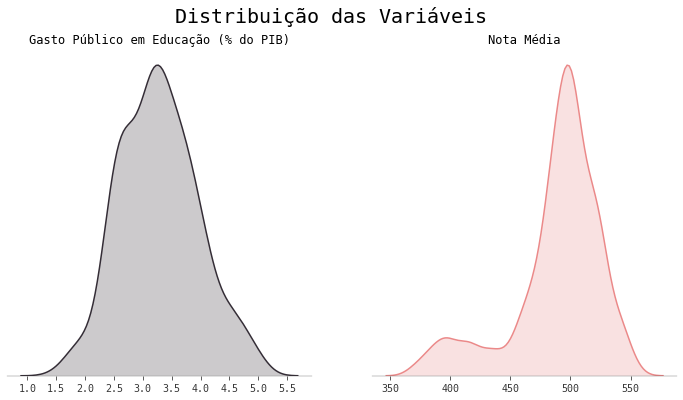

In [258]:
#Vamos visualizar as distribuições dessas colunas.
fig = plt.figure(figsize=(12,6))

#Gerando um espaço de imagem do matplotlib
gs = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.4,figure=fig)

#Criando os sub-espaços (1 maior, e 3 menores)
#No código abaixo estamos forçando os gráficos do PISA a terem todos os mesmo eixo X.
ax0 = fig.add_subplot(gs[:, 1])
plt.yticks([])
plt.yticks([])
plt.title('Nota Média')

ax3 = fig.add_subplot(gs[:, 0])
plt.yticks([])
plt.xticks([x/100 for x in range(100,700,50)])
plt.title('Gasto Público em Educação (% do PIB)')

#Plotando os gráficos de distribuição.
sns.distplot(base_group['Gasto Educ (%)'],ax=ax3,hist=False,axlabel=False,kde_kws={"shade": True},color='#342d36')
sns.distplot(base_group['Nota Média'],ax=ax0,hist=False,axlabel=False,kde_kws={"shade": True},color='#eb8989')

fig.suptitle('Distribuição das Variáveis',fontsize=20)
plt.show()

Percebemos também que a distribuição da média das notas é bimodal. O que isso nos indica é que existe mais de uma realidade na base. Por mais que a maioria dos países siga um comportamento denotado pelo grande pico, as caudas possuem uma segunda moda, o que denota uma segunda realidade.

Um possível motivo para essa distribuição bimodal é a presença de vários países europeus na base. Conforme já vimos anteriormente, a Europa é o continente com mais registros e, portanto, pode ser a responsável por distorcer as distribuições. Vamos então analisar as distribuições abertas por continente. 

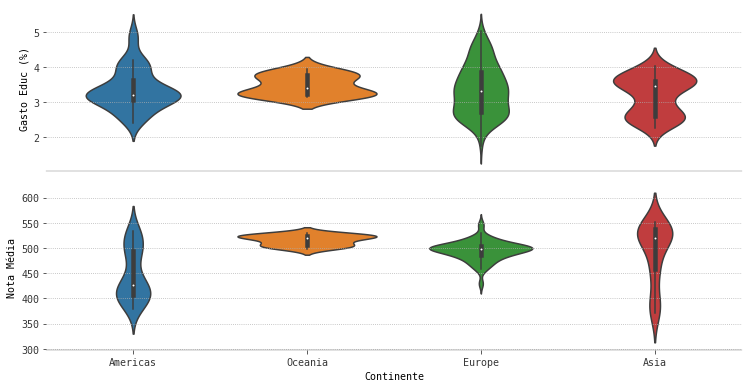

In [331]:
#Plotando gráficos de distribuição abertos por continente.
f,ax = plt.subplots(2,figsize=[10.5,5.5])

sns.violinplot(x="Continente", y="Gasto Educ (%)", data=base_group,
                 showfliers = False,ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_xticks([])
ax[0].grid(axis='y', ls=':')
ax[1].grid(axis='y', ls=':')

sns.violinplot(x="Continente", y="Nota Média", data=base_group,
                 showfliers = False,ax=ax[1])
plt.tight_layout()
plt.show()

Os gráficos de distribuição acima mostram claramente que existem várias realidades nos países. Tanto em termos de desempenho no PISA quanto gasto em educação a Ásia se destaca por possuir duas realidades diferentes. Uma parcela dos países investe em educação e desempenha muito bem, e uma outra parcela não. As Américas possuem uma situação similar a da Ásia, também.

Por fim, como última visualização desta seção, analisaremos as variáveis no tempo. 

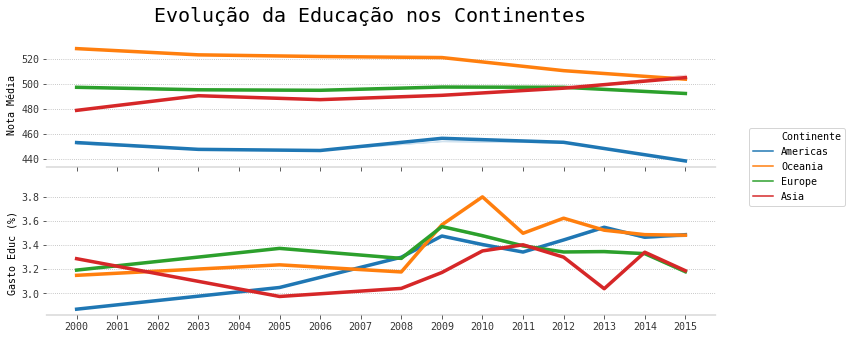

In [266]:
f,ax = plt.subplots(2,figsize=(12,5),sharex=True)

sns.lineplot(data=base_group[base_group['Ano']<=2015],x='Ano',y='Gasto Educ (%)',ax=ax[1],hue='Continente',ci=0,
             legend=False,linewidth=3.5)
sns.lineplot(data=base_group[base_group['Ano']<=2015],x='Ano',y='Nota Média',ax=ax[0],hue='Continente',ci=0,linewidth=3.5)

ax[1].set_xticks([x for x in range(2000,2016)])
ax[1].set_xlabel('')
ax[1].grid(axis='y', ls=':')

ax[0].legend(bbox_to_anchor=(1.05, 0), loc='center left', borderaxespad=0.)
ax[0].grid(axis='y', ls=':')

sns.despine(left=True)
f.suptitle('Evolução da Educação nos Continentes',fontsize=20)
plt.show()

Percebemos que na maioria dos continentes houve um crescimento na fração do PIB investida em educação. Apesar disso, nesses mesmos continentes o desempenho dos alunos no PISA não correspondeu. Suspeitamos que o aumento na fração do PIB investida em educação na realidade não represente um aumento em termos reais. O motivo para essa suspeita foi o aumento brusco que ocorreu em todos os continentes entre os anos de 2008 e 2009, momento no qual o mundo viveu uma grande crise financeira. Os PIBs mundiais podem ter diminuido, aumentando a fração gasta em educação para um nível fixo do gasto.

---

# <font color='#82ad32'>5. Correlação entre Gasto Público em Educação x Desempenho no PISA

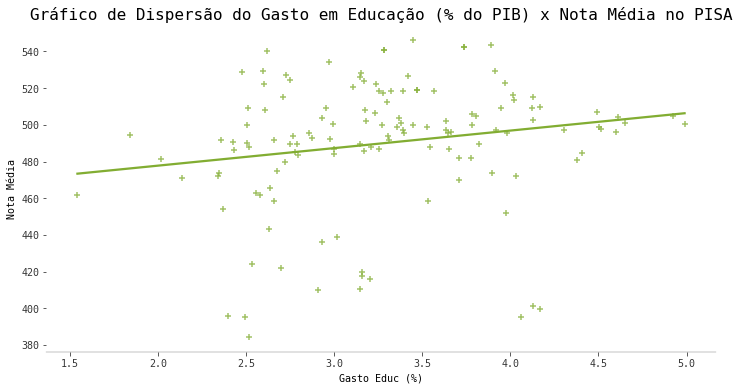

In [345]:
plt.figure(figsize=(12,6))

sns.regplot(data=base_group,x='Gasto Educ (%)',y='Nota Média',color='#82ad32',marker='+',ci=0,
            scatter_kws={'alpha':0.75})

plt.title('Gráfico de Dispersão do Gasto em Educação (% do PIB) x Nota Média no PISA',fontsize=16)
plt.show()